In [8]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import xarray as xr

In [10]:
RANDOM_SEED = 1729
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [11]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame(dict(x=x_out, y=y_out))

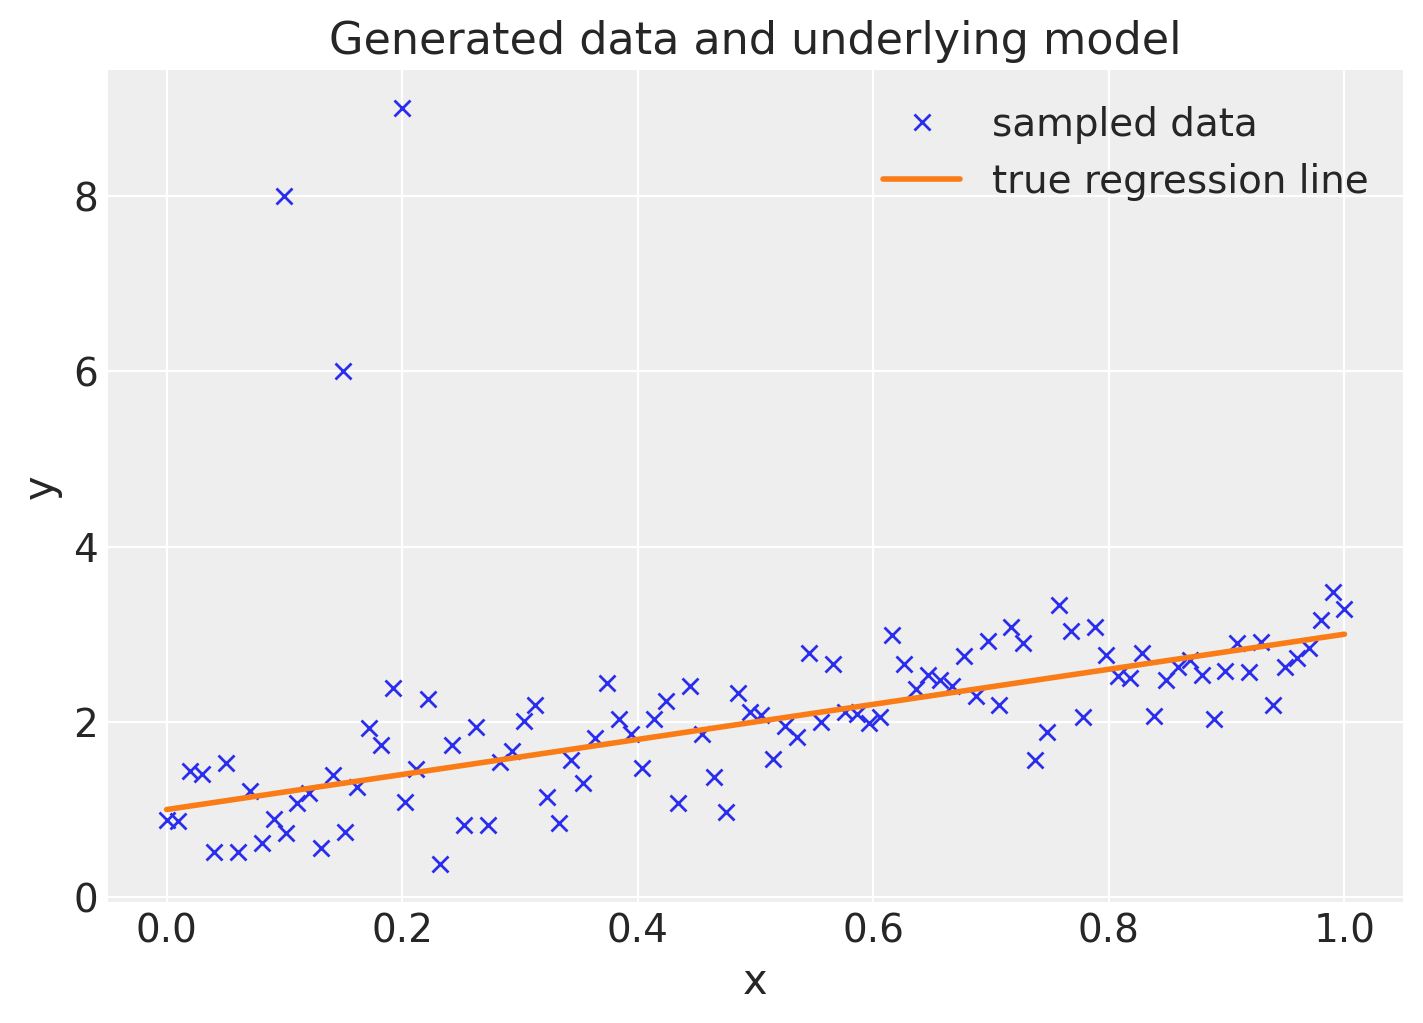

In [12]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [13]:
with pm.Model() as model:
    xdata = pm.ConstantData("x", x_out, dims="obs_id")

    # define priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = pm.Deterministic("mu", intercept + slope * xdata, dims="obs_id")

    # define likelihood
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_out, dims="obs_id")

    # inference
    trace = pm.sample(3000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.


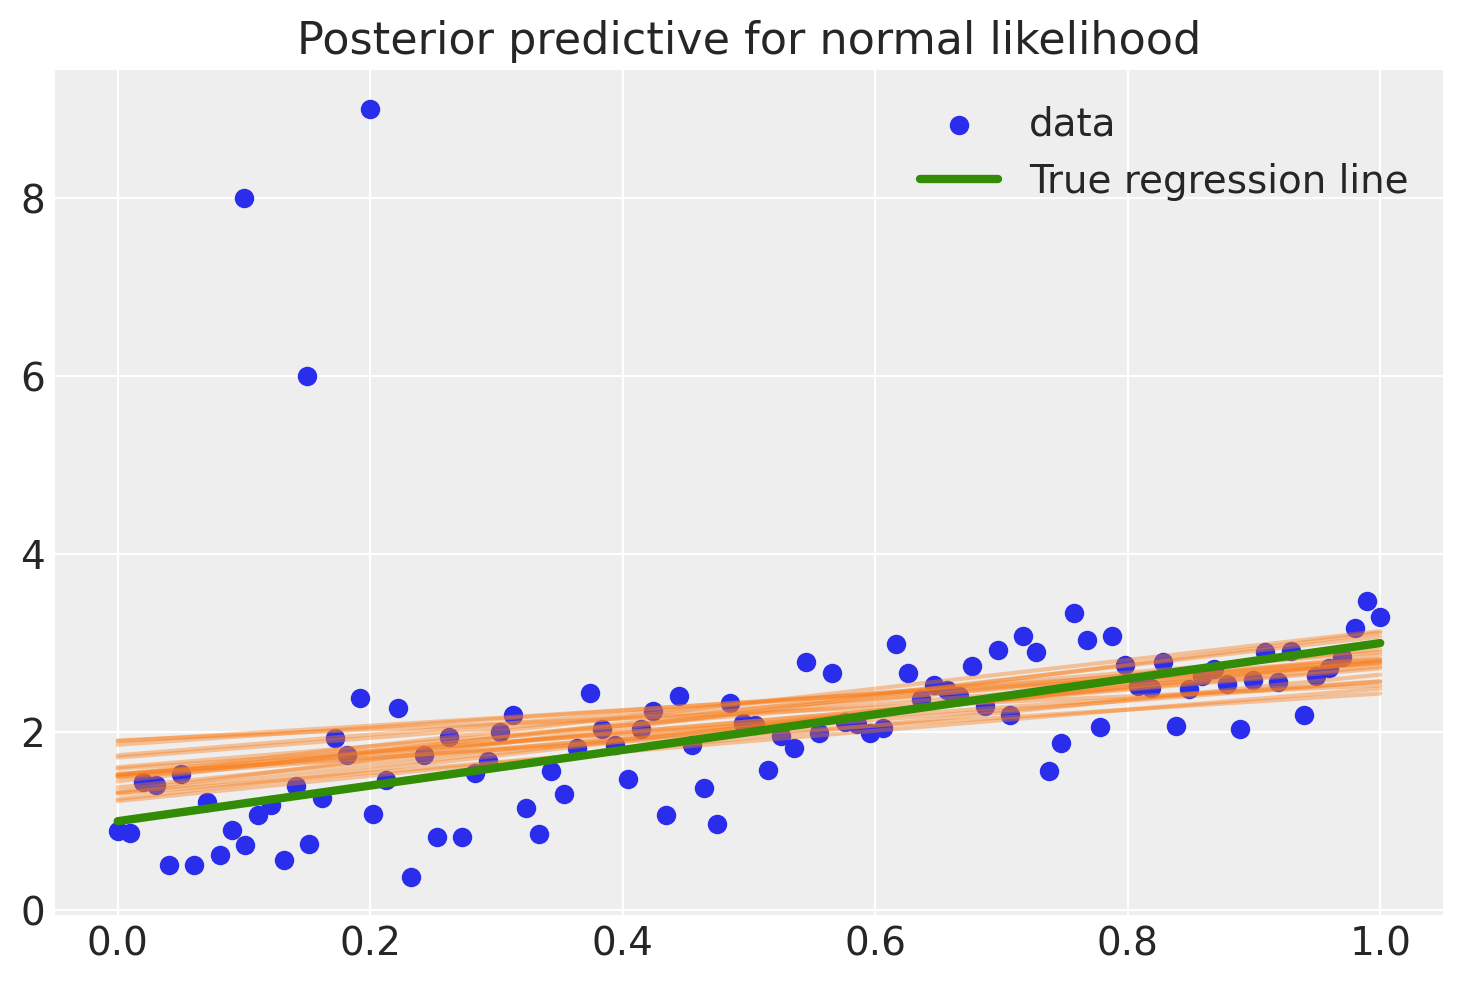

In [14]:
post = az.extract(trace, num_samples=20)
x_plot = xr.DataArray(np.linspace(x_out.min(), x_out.max(), 100), dims="plot_id")
lines = post["intercept"] + post["slope"] * x_plot

plt.scatter(x_out, y_out, label="data")
plt.plot(x_plot, lines.transpose(), alpha=0.4, color="C1")
plt.plot(x, true_regression_line, label="True regression line", lw=3.0, c="C2")
plt.legend(loc=0)
plt.title("Posterior predictive for normal likelihood");